# Seed 생성 확인용 테스트 노트북
http://4.230.26.44:8888

In [1]:
import os
import sys

sys.path.append("/app")
from src.utils.spark_builder import get_spark_session
from pyspark.sql import functions as F

os.environ[
    "PYSPARK_SUBMIT_ARGS"
] = """
    --conf spark.cores.max=2
    --conf spark.executor.memory=8g
    --conf spark.app.name=GDELT_dbt_test
    pyspark-shell
"""

# Spark 세션 생성
spark = get_spark_session("GDELT_dbt_test", "spark://spark-master:7077")
print("✅ Spark 세션 생성 완료")

25/09/25 14:16:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/25 14:16:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


✅ Spark 세션 생성 완료


In [2]:
# Spark Metastore에 존재하는 모든 데이터베이스(스키마) 목록을 확인합니다.
print("📖 사용 가능한 데이터베이스(스키마) 목록:")
spark.sql("SHOW DATABASES").show()

📖 사용 가능한 데이터베이스(스키마) 목록:
+------------+
|   namespace|
+------------+
|     default|
|    gold_dev|
|   gold_prod|
|    seed_dev|
|   seed_prod|
|      silver|
| staging_dev|
|staging_prod|
+------------+



In [3]:
# dbt seed 또는 dbt run으로 생성된 테이블 확인
print("📜 '_dev' 스키마의 테이블 목록:")
spark.sql("SHOW TABLES IN seed_dev").show()
spark.sql("SHOW TABLES IN staging_dev").show()
spark.sql("SHOW TABLES IN gold_dev").show()

📜 '_dev' 스키마의 테이블 목록:


25/09/25 14:02:46 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


+---------+--------------------+-----------+
|namespace|           tableName|isTemporary|
+---------+--------------------+-----------+
| seed_dev|actor_ethnic_grou...|      false|
| seed_dev|actor_organizatio...|      false|
| seed_dev|actor_religion_codes|      false|
| seed_dev|    actor_role_codes|      false|
| seed_dev|  event_detail_codes|      false|
| seed_dev|event_quad_class_...|      false|
| seed_dev|    event_root_codes|      false|
| seed_dev|       geo_adm_codes|      false|
| seed_dev|   geo_country_codes|      false|
| seed_dev|      geo_type_codes|      false|
+---------+--------------------+-----------+



+-----------+--------------------+-----------+
|  namespace|           tableName|isTemporary|
+-----------+--------------------+-----------+
|staging_dev|stg_actors_descri...|      false|
|staging_dev|stg_gkg_detailed_...|      false|
|staging_dev|    stg_seed_mapping|      false|
+-----------+--------------------+-----------+

+---------+--------------------+-----------+
|namespace|           tableName|isTemporary|
+---------+--------------------+-----------+
| gold_dev|gold_daily_detail...|      false|
| gold_dev|gold_daily_events...|      false|
| gold_dev|gold_near_realtim...|      false|
| gold_dev|  gold_superset_view|      false|
+---------+--------------------+-----------+



### Seed 확인 및 테이블 관리

In [ ]:
# Seed 테이블(총 10개)의 샘플 데이터를 5개씩 출력하여 내용 확인
seed_tables = [
    "actor_ethnic_group_codes",
    "actor_organization_codes",
    "actor_religion_codes",
    "actor_role_codes",
    "event_root_codes",
    "event_detail_codes",
    "event_quad_class_codes",
    "geo_adm_codes",
    "geo_country_codes",
    "geo_type_codes",
]

for table in seed_tables:
    print(f"\n 🔍 {table} 테이블 샘플 데이터")
    try:
        spark.sql(f"SELECT * FROM seed_dev.{table} LIMIT 5").show(truncate=False)
    except Exception as e:
        print(f"❌ 테이블 조회 중, 오류 발생: {e}")

생성된 테이블을 삭제할 경우, 아래 코드에 해당 스키마와 "삭제할 테이블명"을 수정하여 실행

In [ ]:
# 삭제할 테이블 이름 목록
tables_to_drop = [
    # "[삭제할 seed 테이블명]"
    "gold_events_by_category_daily"
]
print("🗑️ 기존 테이블 삭제를 시작합니다.")

for table_name in tables_to_drop:
    try:
        spark.sql(f"DROP TABLE IF EXISTS gold_dev.{table_name}")
        print(f"  - 테이블 'gold_dev.{table_name}' 삭제 완료.")
    except Exception as e:
        print(f"  - 테이블 'gold_dev.{table_name}' 삭제 중 오류 발생: {e}")

print("\n✅ 테이블 삭제 작업이 완료되었습니다.")

# 삭제 후 테이블 목록을 다시 확인하여 깨끗해졌는지 확인
print("📜 현재 'gold_dev' 스키마의 테이블 목록:")
spark.sql("SHOW TABLES IN gold_dev").show()

### Staging 폴더의 SQL 파일을 dbt run한 결과 확인

In [6]:
# stg_seed_mapping 결과 확인
print("🥈 [stg_seed_mapping] 뷰")
spark.sql("SELECT * FROM staging_dev.stg_seed_mapping").show(truncate=False)

🥈 [stg_seed_mapping] 뷰


25/09/25 13:57:15 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
25/09/25 13:57:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------------+----------+-------------+-------------------+------------------------+----------+-------------+---------------+------------+-----------+------------+-----------------+-----------+--------------------+--------------------------+--------------------------+--------------------------+----------------------+---------------------------+----------------+------------------+-----------------------+--------------+-------------------+-------------------+---------------------------------------------------+-------------------------+--------------------------------------------------------+-------------------------+--------------+---------------+-----------+-------------+--------------------------+----------------------------+--------------------------+----------------------+---------------------------+----------------+------------------+-----------------------+--------------+-------------------+------------------+---------------------------------------------------+------------------

In [7]:
# stg_actors_description 결과 확인
print("🥈 [stg_actors_description] 뷰")
spark.sql(
    "SELECT * FROM staging_dev.stg_actors_description WHERE actor_full_description IS NULL"
).show(truncate=False)

🥈 [stg_actors_description] 뷰


+----------+----------------------+
|actor_code|actor_full_description|
+----------+----------------------+
+----------+----------------------+



In [8]:
# stg_gkg_detailed_events 결과 확인
print("🥈 [stg_gkg_detailed_events] 뷰")
spark.sql("SELECT * FROM staging_dev.stg_gkg_detailed_events").show(truncate=False)

🥈 [stg_gkg_detailed_events] 뷰


+---------------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------+----------+----------------+------------------+-------+-------------------+
|global_event_id|event_date|source_url                                                                                                                                        |mention_source_name|mention_doc_tone|v2_persons|v2_organizations|v2_enhanced_themes|amounts|processed_at       |
+---------------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------+----------+----------------+------------------+-------+-------------------+
|1264660563     |2025-09-23|https://www.birminghamtimes.com/2025/09/mackenzie-scott-gives-70m-to-uncf-to-financially-strengthen-hbcus/  

### Marts 폴더의 SQL 파일을 dbt run한 결과 확인

In [9]:
# 15분마다 업데이트) gdelt_events 데이터만을 사용하여, 대시보드의 핵심 KPI를 빠르게 집계
print("🥇 [gold_near_realtime_summary] 뷰")
spark.sql("SELECT * FROM gold_dev.gold_near_realtime_summary").show(truncate=False)

🥇 [gold_near_realtime_summary] 뷰


+----------+-------------------------+--------------------------------------------------------+-------------------------+-----------+--------------------+--------------------+--------------+-------------+--------------+-----------------------+--------------------+-------------------+-------------------+-------------------+--------------------------------------------------------------------------------------------+
|event_date|mp_action_geo_country_iso|mp_action_geo_country_eng                               |mp_action_geo_country_kor|event_count|avg_goldstein_scale |avg_tone            |total_mentions|total_sources|total_articles|count_cooperation_event|count_conflict_event|count_anomaly_event|risk_score_daily   |processed_at       |daily_tone_summary                                                                          |
+----------+-------------------------+--------------------------------------------------------+-------------------------+-----------+--------------------+----------

In [3]:
# 1일 마다 업데이트) 모든 Staging 모델들을 조인하고, 스토리 및 KPI 파생 컬럼을 생성하는 상세 이벤트 테이블
print("🥇 [gold_daily_detailed_events] 뷰")
spark.sql("SELECT * FROM gold_dev.gold_daily_detailed_events").show(truncate=False)
# spark.sql("SELECT actor1_info, actor2_info, simple_story, rich_story, headline_story, event_summary, tone_story FROM gold_dev.gold_daily_detailed_events WHERE actor1_info IS NULL").show(truncate=False)

🥇 [gold_daily_detailed_events] 뷰


25/09/25 15:08:19 WARN RetryingMetaStoreClient: MetaStoreClient lost connection. Attempting to reconnect (1 of 1) after 1s. getDatabase
org.apache.thrift.transport.TTransportException: java.net.SocketException: Connection reset
	at org.apache.thrift.transport.TIOStreamTransport.read(TIOStreamTransport.java:129)
	at org.apache.thrift.transport.TTransport.readAll(TTransport.java:86)
	at org.apache.thrift.protocol.TBinaryProtocol.readAll(TBinaryProtocol.java:425)
	at org.apache.thrift.protocol.TBinaryProtocol.readI32(TBinaryProtocol.java:321)
	at org.apache.thrift.protocol.TBinaryProtocol.readMessageBegin(TBinaryProtocol.java:225)
	at org.apache.thrift.TServiceClient.receiveBase(TServiceClient.java:77)
	at org.apache.hadoop.hive.metastore.api.ThriftHiveMetastore$Client.recv_get_database(ThriftHiveMetastore.java:782)
	at org.apache.hadoop.hive.metastore.api.ThriftHiveMetastore$Client.get_database(ThriftHiveMetastore.java:769)
	at org.apache.hadoop.hive.metastore.HiveMetaStoreClient.getData

+---------------+----------+-------------+-------------------+-------------------------+----------+-------------+---------------+------------+-----------+------------+-----------------+-----------+--------------------+--------------------------+--------------------------+--------------------------+----------------------+---------------------------+----------------+------------------+-----------------------+--------------+-------------------+------------------+-----------------------------------------------+-------------------------+----------------------------+-------------------------+--------------+---------------+-----------+---------------+--------------------------+----------------------------+--------------------------+----------------------+---------------------------+----------------+------------------+-----------------------+--------------+-------------------+------------------+------------------------------------------------+-----------------------+-------------------------+-

25/09/25 16:17:59 WARN TransportChannelHandler: Exception in connection from spark-master/10.0.1.237:7077
java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.SocketChannelImpl.throwConnectionReset(SocketChannelImpl.java:394)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:426)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:259)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:724)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:650)
	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:562)
	at io.netty.util.concurrent.SingleThr

In [4]:
df = spark.table("gold_dev.gold_daily_events_category")
row_count = df.count()
col_count = len(df.columns)
print(f" - Row : {row_count:,} 개")
print(f" - Column : {col_count} 개")

spark.sql(
    "SELECT * FROM gold_dev.gold_daily_events_category ORDER BY event_date, mp_action_geo_country_iso ASC"
).show(truncate=False)

25/09/25 14:03:03 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
25/09/25 14:03:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


 - Row : 8,501 개
 - Column : 8 개


+----------+-------------------------+-------------------------+-------------------------+-------------+-------------------+-----------+-------------------+
|event_date|mp_action_geo_country_iso|mp_action_geo_country_eng|mp_action_geo_country_kor|mp_quad_class|mp_event_categories|event_count|processed_at       |
+----------+-------------------------+-------------------------+-------------------------+-------------+-------------------+-----------+-------------------+
|2024-09-23|AFG                      |Afghanistan              |아프가니스탄             |물리적 갈등  |전투               |1          |2025-09-23 11:45:00|
|2024-09-23|AFG                      |Afghanistan              |아프가니스탄             |언어적 협력  |공개 성명 발표     |2          |2025-09-23 09:30:00|
|2024-09-23|AFG                      |Afghanistan              |아프가니스탄             |언어적 협력  |협의               |4          |2025-09-23 23:45:00|
|2024-09-23|ARE                      |The United Arab Emirates |아랍에미리트 연합        |언어적 협력  |공개 성명 발표  

In [5]:
df = spark.table("gold_dev.gold_daily_actor_network")
row_count = df.count()
col_count = len(df.columns)
print(f" - Row : {row_count:,} 개")
print(f" - Column : {col_count} 개")

spark.sql(
    "SELECT * FROM gold_dev.gold_daily_actor_network ORDER BY event_date ASC"
).show(truncate=False)

25/09/26 00:46:25 WARN DeltaLog: Change in the table id detected while updating snapshot. 
Previous snapshot = Snapshot(path=s3a://warehouse/gold_dev/gold_daily_actor_network/_delta_log, version=0, metadata=Metadata(8f317bdd-5100-4514-86d5-dae3f8a34fb5,null,null,Format(parquet,Map()),{"type":"struct","fields":[{"name":"event_date","type":"date","nullable":true,"metadata":{}},{"name":"actor1_country_iso","type":"string","nullable":true,"metadata":{}},{"name":"actor1_country_eng","type":"string","nullable":true,"metadata":{}},{"name":"actor1_country_kor","type":"string","nullable":true,"metadata":{}},{"name":"actor1_geo_lat","type":"double","nullable":true,"metadata":{}},{"name":"actor1_geo_long","type":"double","nullable":true,"metadata":{}},{"name":"actor2_country_iso","type":"string","nullable":true,"metadata":{}},{"name":"actor2_country_eng","type":"string","nullable":true,"metadata":{}},{"name":"actor2_country_kor","type":"string","nullable":true,"metadata":{}},{"name":"actor2_geo_l

 - Row : 1,000 개
 - Column : 17 개


+----------+------------------+--------------------------------------------------------+----------------------+--------------+---------------+------------------+--------------------------------------------------------+------------------+--------------+---------------+-----------+-----------------+-------------------+---------------------------------------------+----------+-------------+
|event_date|actor1_country_iso|actor1_country_eng                                      |actor1_country_kor    |actor1_geo_lat|actor1_geo_long|actor2_country_iso|actor2_country_eng                                      |actor2_country_kor|actor2_geo_lat|actor2_geo_long|event_count|avg_tone         |processed_at       |location_text                                |route_name|tone_category|
+----------+------------------+--------------------------------------------------------+----------------------+--------------+---------------+------------------+--------------------------------------------------------+--

In [ ]:
# Superset 연결용 최종 테이블
print("🥇 [gold_superset_view] 뷰")
spark.sql("SELECT * FROM gold_dev.gold_superset_view").show(truncate=False)

### 시각화 테스트

In [12]:
# 한글 폰트를 찾지 못하는 경우 : WARNING:matplotlib.font_manager:findfont: Font family 'NanumGothic' not found.
import matplotlib
import os

try:
    cache_dir = matplotlib.get_cachedir()
    font_cache_file = os.path.join(
        cache_dir, "fontlist-v330.json"
    )  # 버전마다 파일명이 다를 수 있습니다.

    if os.path.exists(font_cache_file):
        os.remove(font_cache_file)
        print(
            f"✅ Matplotlib 폰트 캐시 파일({font_cache_file})을 성공적으로 삭제했습니다."
        )
    else:
        print("ℹ️ 이미 삭제되었거나, 다른 이름의 캐시 파일이 사용 중일 수 있습니다.")
        # 만약 위 코드로 해결되지 않으면, 캐시 디렉토리 전체를 비웁니다.
        os.system(f"rm -rf {cache_dir}/*")
        print(f"✅ Matplotlib 캐시 디렉토리({cache_dir})의 모든 파일을 삭제했습니다.")

except Exception as e:
    print(f"❌ 폰트 캐시를 삭제하는 중 오류 발생: {e}")

print(
    "\n‼️‼️‼️ 중요: 이제 메뉴에서 'Kernel' > 'Restart Kernel'을 실행하여 런타임을 반드시 재시작해주세요! ‼️‼️‼️"
)

ℹ️ 이미 삭제되었거나, 다른 이름의 캐시 파일이 사용 중일 수 있습니다.
✅ Matplotlib 캐시 디렉토리(/root/.cache/matplotlib)의 모든 파일을 삭제했습니다.

‼️‼️‼️ 중요: 이제 메뉴에서 'Kernel' > 'Restart Kernel'을 실행하여 런타임을 반드시 재시작해주세요! ‼️‼️‼️


시각화에 필요한 라이브러리를 설치합니다...

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✅ Python 시각화 라이브러리(matplotlib, seaborn, squarify) 설치 완료.

시스템 패키지 목록을 최신 상태로 업데이트합니다...
나눔고딕 폰트 설치를 시작합니다...
✅ 폰트 설치 완료.

Matplotlib의 폰트 캐시를 재구성합니다...
✅ 캐시 재구성 완료.

✅ Matplotlib에 'NanumGothic' 폰트를 성공적으로 등록했습니다.

'gold_dev.gold_daily_events_category' 테이블에서 데이터를 불러옵니다...


25/09/25 14:17:05 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
25/09/25 14:17:25 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/09/25 14:17:40 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/09/25 14:17:55 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/09/25 14:18:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


✅ 데이터 로딩 및 변환 완료.

'카테고리 별 이벤트 분포' 막대그래프 시각화를 시작합니다...


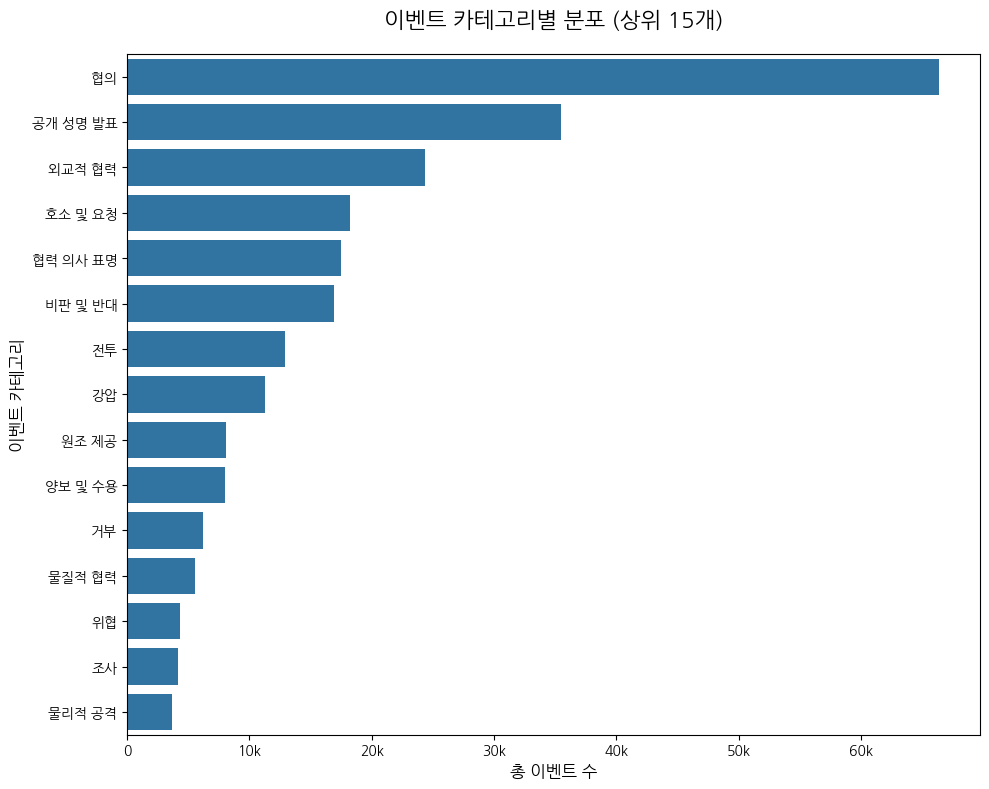

✅ 막대그래프 생성 완료.

'이벤트 타입 분포' 트리맵 시각화를 시작합니다...


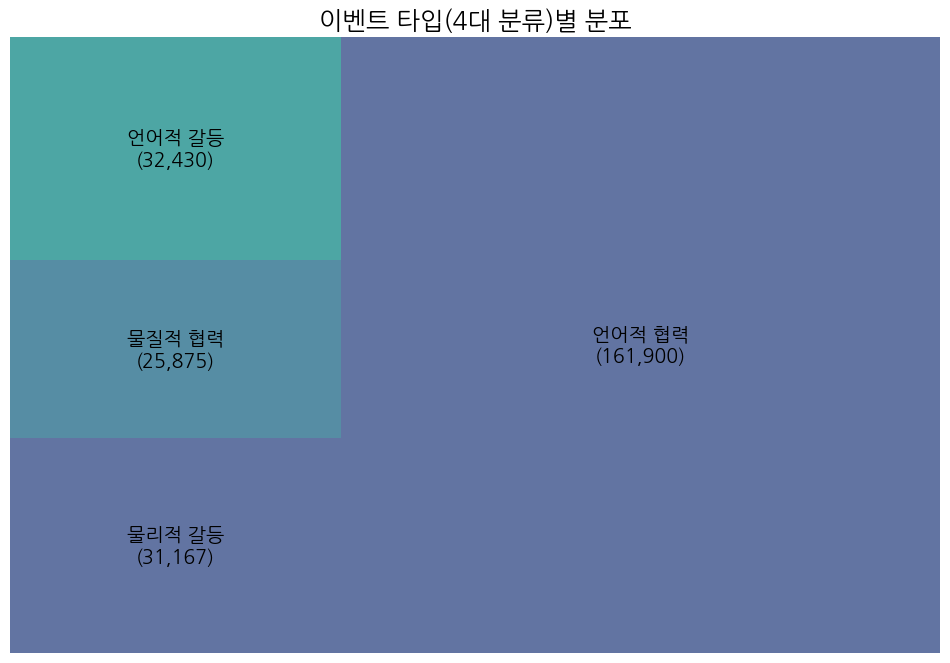

✅ 트리맵 생성 완료.


In [2]:
import sys
import os

# --- 0단계: 모든 필수 Python 라이브러리 설치 ---
print("시각화에 필요한 라이브러리를 설치합니다...")
!{sys.executable} -m pip install matplotlib seaborn squarify
print("✅ Python 시각화 라이브러리(matplotlib, seaborn, squarify) 설치 완료.")


# --- 라이브러리 임포트 ---
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import squarify
from pyspark.sql.functions import sum as spark_sum
from matplotlib.ticker import FuncFormatter


# --- 1단계: 시스템 패키지 목록 업데이트 및 한글 폰트 설치 ---
print("\n시스템 패키지 목록을 최신 상태로 업데이트합니다...")
os.system("apt-get -qq update")
print("나눔고딕 폰트 설치를 시작합니다...")
os.system("apt-get -qq -y install fonts-nanum")
print("✅ 폰트 설치 완료.")

# --- 2단계: Matplotlib 폰트 캐시 재구성 ---
print("\nMatplotlib의 폰트 캐시를 재구성합니다...")
try:
    # 이전 버전 호환성을 위해 _rebuild()를 먼저 시도
    fm._rebuild()
except AttributeError:
    # 최신 버전에서는 캐시를 직접 삭제
    import matplotlib

    cache_dir = matplotlib.get_cachedir()
    if os.path.exists(cache_dir):
        os.system(f"rm -rf {cache_dir}/*")
print("✅ 캐시 재구성 완료.")


# --- 3단계: Matplotlib 기본 폰트 설정 ---
try:
    plt.rc("font", family="NanumGothic")
    plt.rcParams["axes.unicode_minus"] = False
    print("\n✅ Matplotlib에 'NanumGothic' 폰트를 성공적으로 등록했습니다.")

    # --- 4단계: 데이터 로딩 및 준비 ---
    table_name = "gold_dev.gold_daily_events_category"
    print(f"\n'{table_name}' 테이블에서 데이터를 불러옵니다...")
    df = spark.table(table_name)

    # 시각화에 필요한 컬럼만 선택하여 Pandas로 변환 (날짜 타입 변환 오류 방지)
    pandas_df = df.select(
        "mp_quad_class", "mp_event_categories", "event_count"
    ).toPandas()
    print("✅ 데이터 로딩 및 변환 완료.")

    # --- 5단계: 카테고리 별 이벤트 분포 (가로 막대그래프) ---
    print("\n'카테고리 별 이벤트 분포' 막대그래프 시각화를 시작합니다...")

    category_agg = (
        pandas_df.groupby("mp_event_categories")["event_count"].sum().reset_index()
    )
    category_agg = category_agg.sort_values(by="event_count", ascending=False).head(15)

    plt.figure(figsize=(10, 8))
    barplot = sns.barplot(
        x="event_count", y="mp_event_categories", data=category_agg, orient="h"
    )
    plt.title("이벤트 카테고리별 분포 (상위 15개)", fontsize=16, pad=20)
    plt.xlabel("총 이벤트 수", fontsize=12)
    plt.ylabel("이벤트 카테고리", fontsize=12)

    def format_k(x, pos):
        return f"{x*1e-3:,.0f}k" if x > 0 else "0"

    formatter = FuncFormatter(format_k)
    barplot.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.show()
    print("✅ 막대그래프 생성 완료.")

    # --- 6단계: 이벤트 타입 분포 (트리맵) ---
    print("\n'이벤트 타입 분포' 트리맵 시각화를 시작합니다...")

    quad_class_agg = (
        pandas_df.groupby("mp_quad_class")["event_count"].sum().reset_index()
    )

    sizes = quad_class_agg["event_count"]
    labels = quad_class_agg.apply(
        lambda x: f"{x['mp_quad_class']}\n({x['event_count']:,})", axis=1
    )

    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=sizes, label=labels, alpha=0.8, text_kwargs={"fontsize": 14})

    plt.title("이벤트 타입(4대 분류)별 분포", fontsize=18)
    plt.axis("off")
    plt.show()
    print("✅ 트리맵 생성 완료.")

except Exception as e:
    print(f"❌ 데이터를 불러오거나 시각화하는 중 오류가 발생했습니다: {e}")

### Gold_dev의 모든 테이블 크기 확인용

In [6]:
schema_name = "gold_dev"

try:
    # --- 지정된 스키마의 모든 테이블 목록을 가져옵니다. ---
    tables_df = spark.sql(f"SHOW TABLES IN {schema_name}")

    # DataFrame에서 테이블 이름만 추출하여 Python 리스트로 변환합니다.
    table_names = [row.tableName for row in tables_df.collect()]

    if not table_names:
        print(f"ℹ️ '{schema_name}' 스키마에서 테이블을 찾을 수 없습니다.")
    else:
        print(
            f"🥇 '{schema_name}' 스키마에서 총 {len(table_names)}개의 테이블을 발견했습니다.\n"
        )

    # --- 반복문을 사용하여 각 테이블의 정보를 조회하고 출력합니다. ---
    for table in table_names:
        full_table_name = f"{schema_name}.{table}"
        print(f"테이블명: {full_table_name}")

        try:
            df = spark.table(full_table_name)
            row_count = df.count()
            col_count = len(df.columns)
            print(f" - 행(Row)의 수: {row_count:,} 개")
            print(f" - 열(Column)의 수: {col_count} 개\n")

        except Exception as e:
            print(f"❌ 테이블 '{full_table_name}' 조회 중 오류 발생: {e}\n")

except Exception as e:
    print(f"❌ 스키마 '{schema_name}'의 테이블 목록을 가져오는 중 오류 발생: {e}")

🥇 'gold_dev' 스키마에서 총 4개의 테이블을 발견했습니다.

테이블명: gold_dev.gold_daily_detailed_events


 - 행(Row)의 수: 258,338 개
 - 열(Column)의 수: 81 개

테이블명: gold_dev.gold_daily_events_category
 - 행(Row)의 수: 8,501 개
 - 열(Column)의 수: 8 개

테이블명: gold_dev.gold_near_realtime_summary


 - 행(Row)의 수: 1,137 개
 - 열(Column)의 수: 16 개

테이블명: gold_dev.gold_superset_view


 - 행(Row)의 수: 252,909 개
 - 열(Column)의 수: 15 개



### Spark 세션 종료

In [ ]:
spark.stop()
print("\n✅ Spark 세션이 종료되었습니다.")